In [ ]:
import numpy as np
import pandas as pd

from sklearn import preprocessing

import pymc3 as pm
import theano.tensor as tt

from matplotlib import pylab as plt
import seaborn as sns

# plt.style.use('fivethirtyeight')
plt.style.use("bmh")
# sns.set(style="whitegrid")

import arviz as az
# az.style.use("arviz-whitegrid")

%load_ext watermark
%matplotlib inline

In [2]:
%watermark -v -d -t -z -u -r -iv

pymc3            3.8
arviz            0.5.1
sklearn          0.21.3
theano           1.0.4
seaborn          0.9.0
numpy            1.17.3
pandas           0.25.2
matplotlib.pylab 1.17.3
last updated: 2019-12-03 08:21:48 PST 

CPython 3.7.4
IPython 7.9.0
Git repo:


In [3]:
n_chains = 3
n_cores = 3
n_draws = 4000
n_tunes = int(n_draws/2)

SEED = 42

SAMPLE_KWARGS = {
    "chains": n_chains,
    "cores": n_cores,
    "draws": n_draws,
    "tune": n_tunes,
    "target_accept": 0.95,
    "random_seed": [SEED+s for s in np.arange(0, n_chains)]
}
SAMPLE_KWARGS

{'chains': 3,
 'cores': 3,
 'draws': 4000,
 'tune': 2000,
 'target_accept': 0.95,
 'random_seed': [42, 43, 44]}

In [294]:
def summarize(df, grouping):
    return (
        (df
         .groupby(grouping)["fourth_down", "fourth_down_attempts", "fourth_down_conversions"]
         .sum()
        )
        .reset_index()
    )

In [295]:
def add_pct(df):
    df["fourth_down_attempt_pct"] = df["fourth_down_attempts"]/df["fourth_down"]
    df["fourth_down_conversion_pct"] = df["fourth_down_conversions"]/df["fourth_down_attempts"]
    
    return df


In [467]:
# flt = "season < 2019" 
# cutoff_date = "2019-11-11"
df = (pd
      .read_csv("fourth_downs.csv")
      .query("is_field_goal_attempt == False")
     )

df.rename(columns={"off_team_code": "team_code"}, inplace=True)
df["game_date"] = pd.to_datetime(df["game_date"])

# We start game weeks on Tuesday
df["game_week"] = df["game_date"] - pd.offsets.Week(weekday=1)
df["game_week_code"] = df["game_week"].dt.strftime("%Y%m%d")
df["season_week"] = df.assign(season_week=df.groupby(["season"])["game_week"].rank(method="dense", ascending=True))["season_week"].astype(int)
df["season_code"] = "R" + df["season"].astype(str)

# df["is_training_period"] = df["game_date"] <= cutoff_date

df["fourth_down"] = 1
df["fourth_down_attempts"] = df["is_fourth_down_attempt"].astype(int)
df["fourth_down_conversions"] = df["is_fourth_down_converted"].astype(int)

# df.set_index("game_date", inplace=True)
df.to_hdf("fourth_downs.hd5", "fourth_downs")

In [468]:
# (df[["season", "game_week"]]
#  .query("season >= 2018")
#  .assign(season_week=df.groupby(["season"])["game_week"].rank(method="dense", ascending=True))
# )

In [469]:
df["game_date"].max()

Timestamp('2019-11-18 00:00:00')

In [470]:
df.sample(10)

,season,game_id,game_date,quarter,drive,play_id,play_time,team_code,off_team_type,def_team_code,...,is_fourth_down_failed,is_penalty,yards_gained,game_week,game_week_code,season_week,season_code,fourth_down,fourth_down_attempts,fourth_down_conversions
17019,2013,2013092909,2013-09-29,2,9,1941,02:22,PHI,away,DEN,...,False,True,0,2013-09-24,20130924,4,R2013,1,0,0
26647,2015,2015112602,2015-11-26,4,22,4091,02:53,CHI,away,GB,...,False,False,0,2015-11-24,20151124,12,R2015,1,0,0
19641,2013,2013122200,2013-12-22,1,1,126,13:11,MIA,away,BUF,...,False,False,0,2013-12-17,20131217,16,R2013,1,0,0
14828,2012,2012120201,2012-12-02,2,10,1831,01:56,MIN,away,GB,...,False,True,0,2012-11-27,20121127,13,R2012,1,0,0
9093,2011,2011100903,2011-10-09,3,15,2450,03:25,JAX/JAC,home,CIN,...,False,False,0,2011-10-04,20111004,5,R2011,1,0,0
989,2009,2009101100,2009-10-11,4,17,3275,05:36,CIN,away,BAL,...,False,False,0,2009-10-06,20091006,5,R2009,1,0,0
15558,2012,2012121700,2012-12-17,4,26,3962,00:53,TEN,home,NYJ,...,False,False,0,2012-12-11,20121211,15,R2012,1,0,0
19317,2013,2013120808,2013-12-08,2,9,1422,07:58,WAS,home,KC,...,False,False,0,2013-12-03,20131203,14,R2013,1,0,0
6190,2010,2010111408,2010-11-14,2,8,1490,05:06,NYG,home,DAL,...,False,False,0,2010-11-09,20101109,10,R2010,1,0,0
16613,2013,2013092200,2013-09-22,3,13,2737,07:54,HOU,away,BAL,...,False,True,0,2013-09-17,20130917,3,R2013,1,0,0


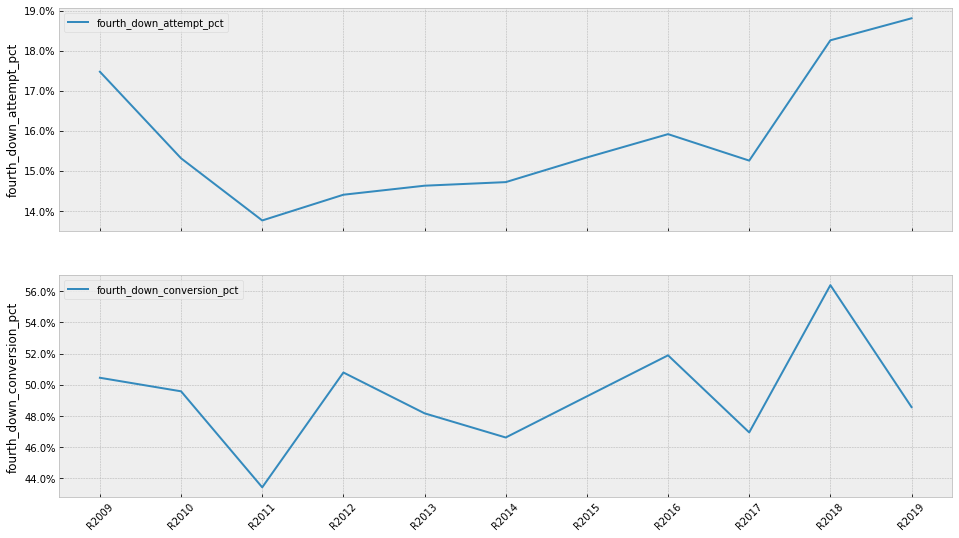

In [473]:
_, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)
for ax, col in zip(axes, ["fourth_down_attempt_pct", "fourth_down_conversion_pct"]):
#     print(data_)
    sns.lineplot(x="season_code", y=col, data=df_season, ax=ax, ci=95, label=col)
    vals = ax.get_yticks()
    _ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
    ax.set_xlabel(None)
    ax.legend()
    plt.xticks(rotation=45)

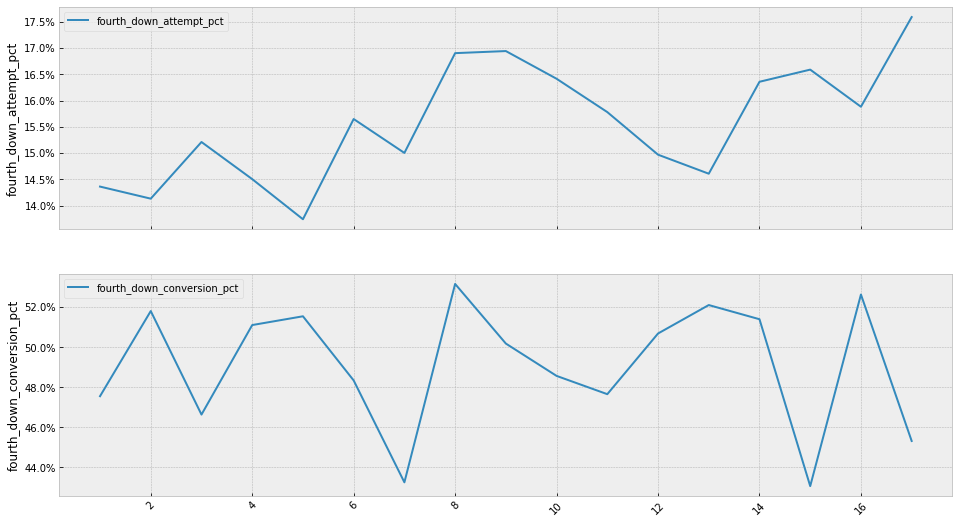

In [474]:
_, axes = plt.subplots(2, 1, figsize=(16, 9), sharex=True)
for ax, col in zip(axes, ["fourth_down_attempt_pct", "fourth_down_conversion_pct"]):
#     print(data_)
    sns.lineplot(x="season_week", y=col, data=df_week, ax=ax, ci=None, label=col)
    vals = ax.get_yticks()
    _ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
    ax.set_xlabel(None)
    ax.legend()
    plt.xticks(rotation=45)

In [593]:
# training_filter = df["is_training_period"] == True
df_week = add_pct(summarize(df, ["season_week"]))#.set_index("game_week_code"))
df_week_team = add_pct(summarize(df, ["season_code", "season_week", "team_code"]))
df_season_team = add_pct(summarize(df, ["season_code", "team_code"]))

In [594]:
df_season = add_pct(summarize(df, ["season_code"]))
df_team = add_pct(summarize(df, ["team_code"]))

In [595]:
def metric_heatmap(df, x_col="team_code", y_col="season_code", value_col="fourth_down_attempt_pct", title="", fmt=".0%"):
    
    _, ax = plt.subplots(1, 1, figsize=(16, 16))

    sns.heatmap(
        pd.crosstab(df[x_col], 
                    df[y_col], 
                    values=df[value_col], 
                    aggfunc=np.sum, margins=False),
        cmap="Blues", fmt=fmt, annot=True, cbar=False,
        ax=ax
    )
    ax.set_ylabel("Team")
    ax.set_xlabel("Regular Season")
    ax.set_title(title)

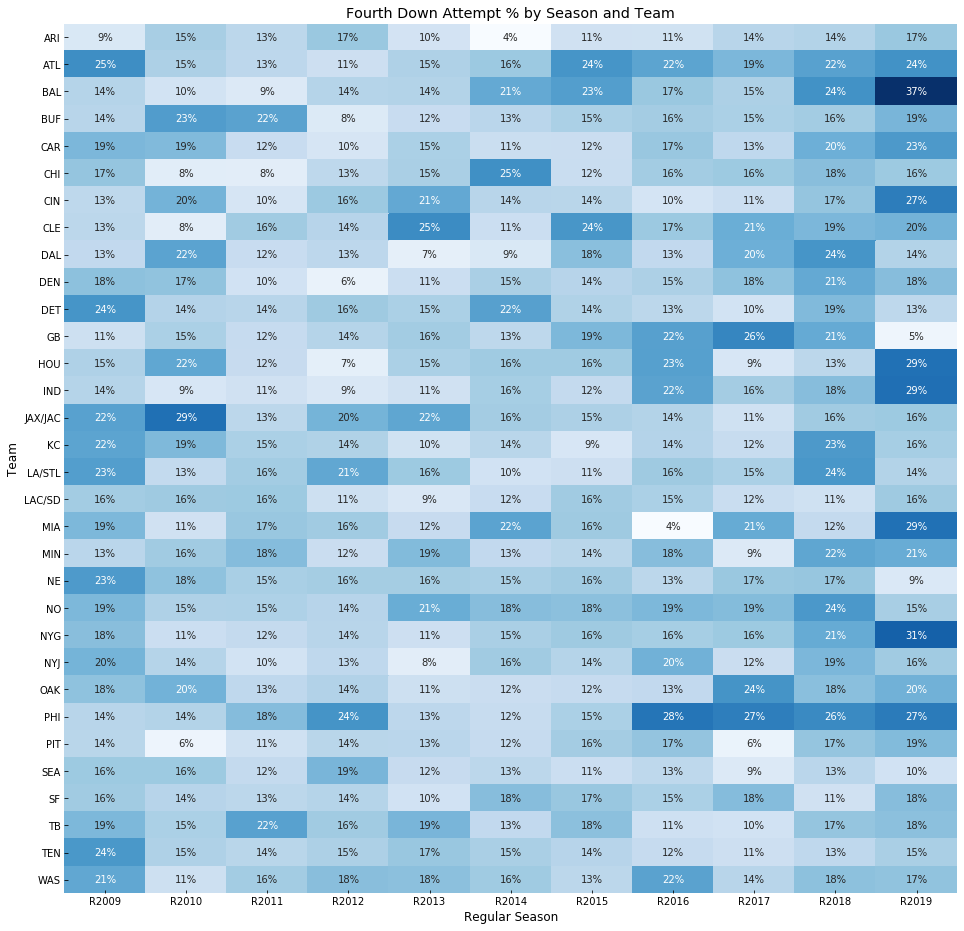

In [596]:
metric_heatmap(df_season_team, value_col="fourth_down_attempt_pct", title="Fourth Down Attempt % by Season and Team")

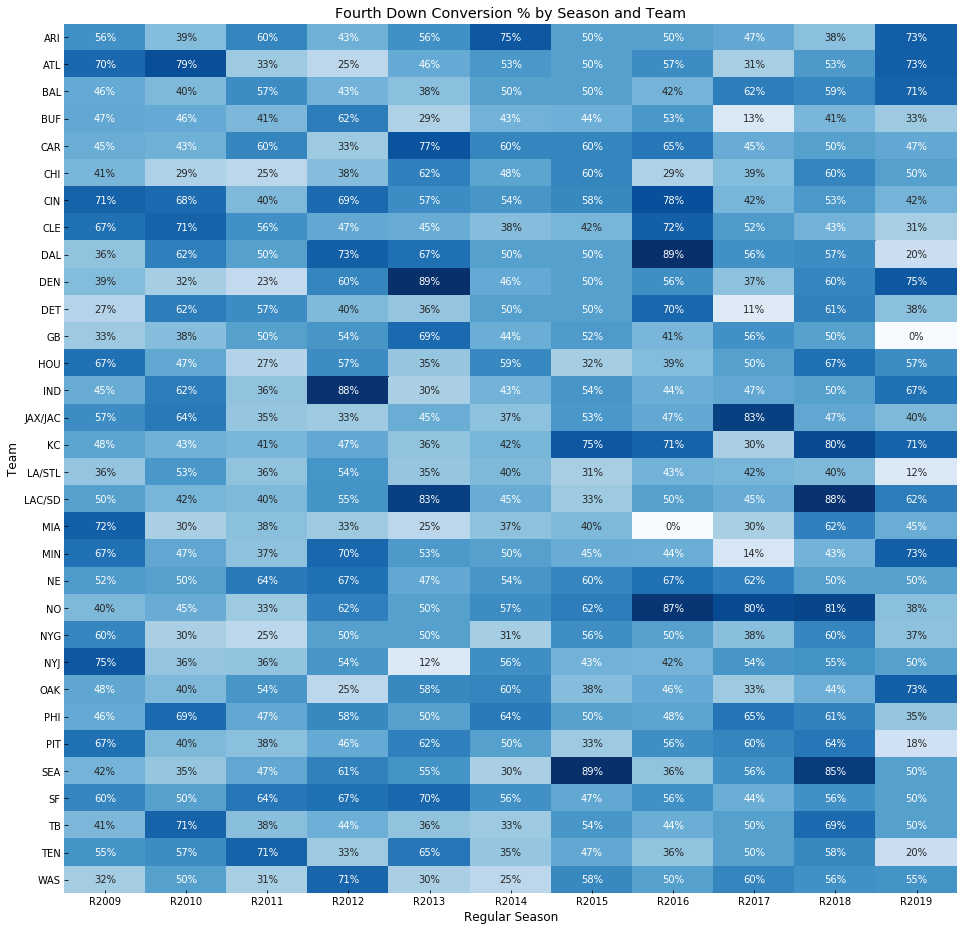

In [547]:
metric_heatmap(df_season_team, value_col="fourth_down_conversion_pct", title="Fourth Down Conversion % by Season and Team")

## Label Encoding

In [553]:
le = preprocessing.LabelEncoder()
team_idx = le.fit_transform(df_week_team["team_code"])
n_teams = len(set(team_idx))
season_idx = le.fit_transform(df_week_team["season_code"])
n_seasons = len(set(season_idx))
week_idx = le.fit_transform(df_week_team["season_week"])
n_weeks = len(set(week_idx))

n_teams, n_seasons, n_weeks

(32, 11, 17)

In [555]:
teams = df_week_team["team_code"].unique()
seasons = df_week_team["season_code"].unique()
weeks = df_week_team["season_week"].unique()

fourth_down_obs = df_week_team["fourth_down"].values
attempts_obs = df_week_team["fourth_down_attempts"].values
conversions_obs = df_week_team["fourth_down_conversions"].values

In [556]:
teams, seasons, weeks, n_teams, n_seasons, n_weeks

(array(['ARI', 'ATL', 'BAL', 'BUF', 'CAR', 'CHI', 'CIN', 'CLE', 'DAL',
        'DEN', 'DET', 'GB', 'HOU', 'IND', 'JAX/JAC', 'KC', 'LA/STL',
        'LAC/SD', 'MIA', 'MIN', 'NE', 'NO', 'NYG', 'NYJ', 'OAK', 'PHI',
        'PIT', 'SEA', 'SF', 'TB', 'TEN', 'WAS'], dtype=object),
 array(['R2009', 'R2010', 'R2011', 'R2012', 'R2013', 'R2014', 'R2015',
        'R2016', 'R2017', 'R2018', 'R2019'], dtype=object),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17]),
 32,
 11,
 17)

## Beta-Binomial Model

from https://docs.pymc.io/notebooks/hierarchical_partial_pooling.html:

> We will assume that there exists a hidden factor (phi) related to the expected performance for all players (not limited to our 18). Since the population mean is an unknown value between 0 and 1, it must be bounded from below and above. Also, we assume that nothing is known about global average. Hence, a natural choice for a prior distribution is the uniform distribution.

> Next, we introduce a hyperparameter kappa to account for the variance in the population batting averages, for which we will use a bounded Pareto distribution. This will ensure that the estimated value falls within reasonable bounds. These hyperparameters will be, in turn, used to parameterize a beta distribution, which is ideal for modeling quantities on the unit interval. The beta distribution is typically parameterized via a scale and shape parameter, it may also be parametrized in terms of its mean μ∈[0,1]
and sample size (a proxy for variance) ν=α+β(ν>0)


> The final step is to specify a sampling distribution for the data (hit or miss) for every player, using a Binomial distribution. This is where the data are brought to bear on the model.

> We could use pm.Pareto('kappa', m=1.5), to define our prior on kappa, but the Pareto distribution has very long tails. Exploring these properly is difficult for the sampler, so we use an equivalent but faster parametrization using the exponential distribution. We use the fact that the log of a Pareto distributed random variable follows an exponential distribution.

In [557]:
len(attempts_obs), n_seasons*n_teams*n_weeks

(5438, 5984)

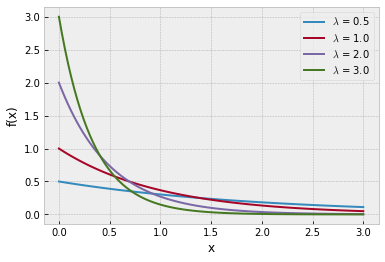

In [558]:
import scipy.stats as st

x = np.linspace(0, 3, 100)
for lam in [0.5, 1., 2., 3.]:
    pdf = st.expon.pdf(x, scale=1.0/lam)
    plt.plot(x, pdf, label=r'$\lambda$ = {}'.format(lam))
plt.xlabel('x', fontsize=12)
plt.ylabel('f(x)', fontsize=12)
plt.legend(loc=1)
plt.show()

In [559]:
def beta_binomial_model_multi(X_obs, y_obs, n_thetas, theta_idx, **kwargs):
    
    with pm.Model() as model:
    
#         phi = pm.Beta("phi", 1, 1)
        phi = pm.Uniform("phi", 0, 1)

        kappa_log = pm.Exponential("kappa_log", lam=kwargs.get("lam", 3))
        kappa = pm.Deterministic("kappa", tt.exp(kappa_log))

        thetas = pm.Beta("theta", 
                    alpha=phi*kappa, 
                    beta=(1.0-phi)*kappa, 
                    shape=n_thetas)

        y = pm.Binomial("y", n=X_obs, p=thetas[theta_idx], observed=y_obs)
    
    return model

def beta_binomial_model(X_obs, y_obs, **kwargs):
    
    with pm.Model() as model:
    
        alpha = pm.HalfNormal("alpha", sd=1)
        beta = pm.HalfNormal("beta", sd=1)

        theta = pm.Beta("theta", 
                    alpha=alpha, 
                    beta=beta)
        
        y = pm.Binomial("y", n=X_obs, p=theta, observed=y_obs)
    
    return model

In [560]:
attempts_model = beta_binomial_model(fourth_down_obs, attempts_obs, lam=1)
attempts_model

In [561]:
attempts_season_model = beta_binomial_model_multi(fourth_down_obs, attempts_obs, n_seasons, season_idx)
attempts_season_model

In [562]:
attempts_team_model = beta_binomial_model_multi(fourth_down_obs, attempts_obs, n_teams, team_idx, lam=5)
attempts_team_model

In [563]:
attempts_week_model = beta_binomial_model_multi(fourth_down_obs, attempts_obs, n_weeks, week_idx)
attempts_week_model

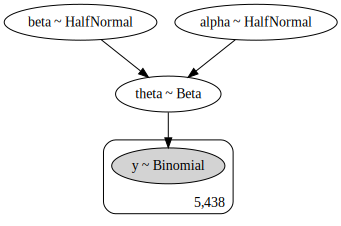

In [564]:
pm.model_to_graphviz(attempts_model)

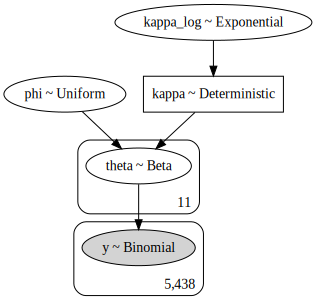

In [565]:
pm.model_to_graphviz(attempts_season_model)

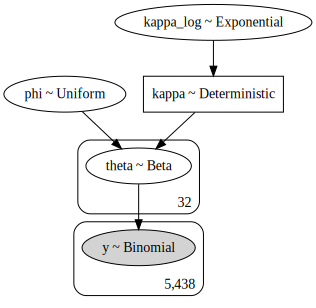

In [566]:
pm.model_to_graphviz(attempts_team_model)

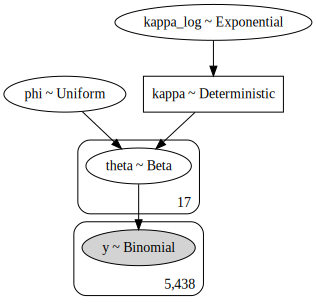

In [567]:
pm.model_to_graphviz(attempts_week_model)

In [568]:
with attempts_model:
    attempts_trace = pm.sample(**SAMPLE_KWARGS)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta, beta, alpha]
Sampling 3 chains, 0 divergences: 100%|██████████| 18000/18000 [00:11<00:00, 1620.52draws/s]


In [569]:
with attempts_season_model:
    attempts_season_trace = pm.sample(**SAMPLE_KWARGS)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta, kappa_log, phi]
Sampling 3 chains, 0 divergences: 100%|██████████| 18000/18000 [00:28<00:00, 621.83draws/s]


In [570]:
with attempts_team_model:
    attempts_team_trace = pm.sample(**SAMPLE_KWARGS)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta, kappa_log, phi]
Sampling 3 chains, 0 divergences: 100%|██████████| 18000/18000 [00:34<00:00, 523.75draws/s]


In [571]:
with attempts_week_model:
    attempts_week_trace = pm.sample(**SAMPLE_KWARGS)    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [theta, kappa_log, phi]
Sampling 3 chains, 0 divergences: 100%|██████████| 18000/18000 [00:31<00:00, 574.65draws/s]


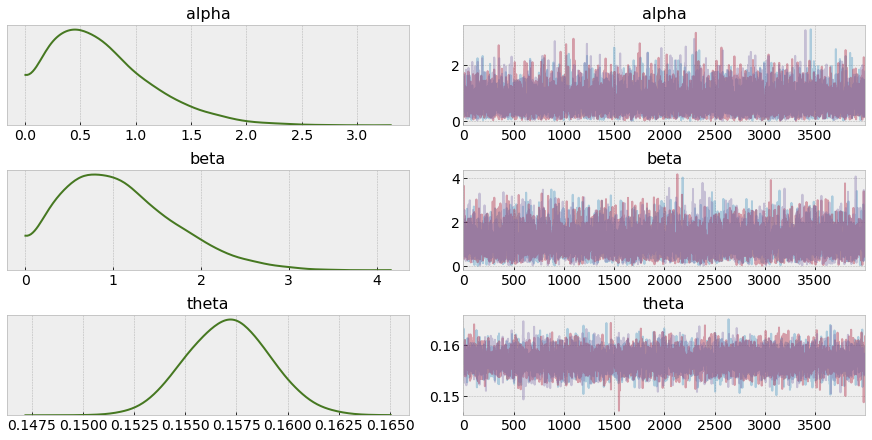

In [572]:
pm.traceplot(attempts_trace, combined=True, compact=True, var_names=["alpha", "beta", "theta"], divergences=None);

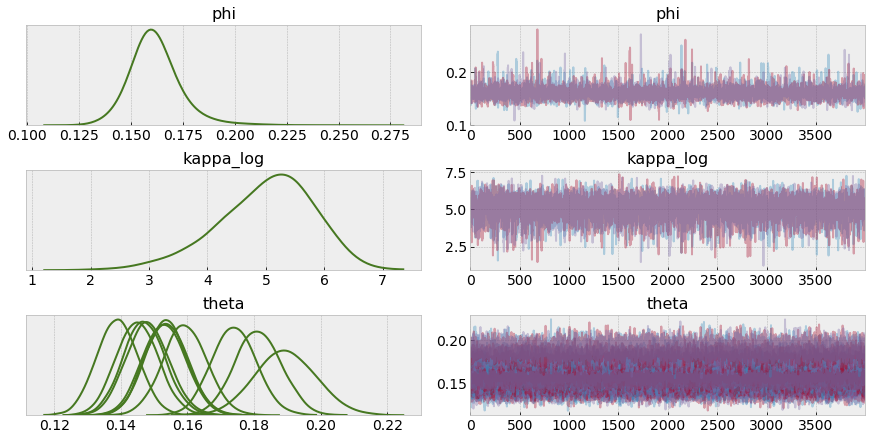

In [573]:
pm.traceplot(attempts_season_trace, combined=True, compact=True, var_names=["phi", "kappa_log", "theta"], divergences=None);

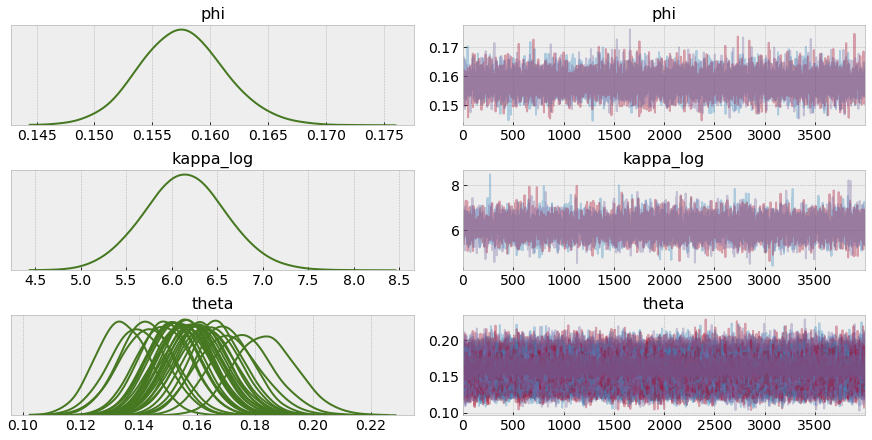

In [574]:
pm.traceplot(attempts_team_trace, combined=True, compact=True, var_names=["phi", "kappa_log", "theta"], divergences=None);

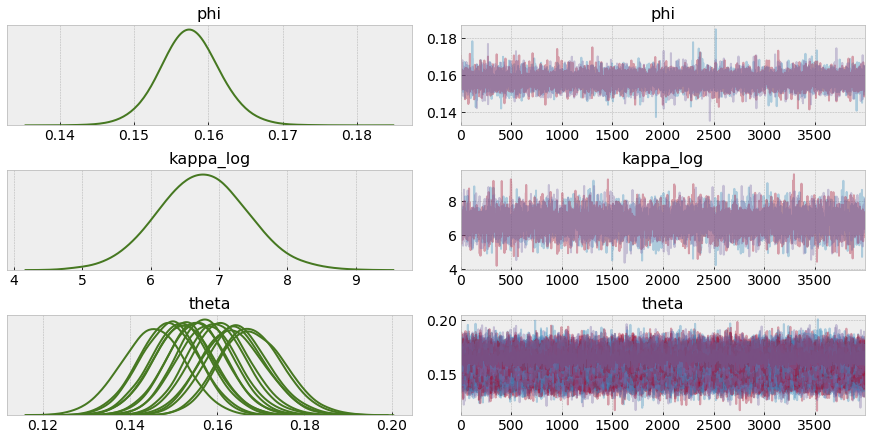

In [575]:
pm.traceplot(attempts_week_trace, combined=True, compact=True, var_names=["phi", "kappa_log", "theta"], divergences=None);

In [576]:
compare_dict = {"Attempts/[Pooled]": attempts_trace, 
                "Attempts/Season": attempts_season_trace, 
                "Attempts/Team": attempts_team_trace,
                "Attempts/Week": attempts_week_trace,
               }
df_compare = az.compare(compare_dict, ic="loo", )
df_compare

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Attempts/Season,0,13165.5,11.8638,0,0.967898,104.431,0,False,deviance
Attempts/Team,1,13200.6,25.1635,35.123,0.0227911,105.532,18.1899,False,deviance
Attempts/[Pooled],2,13202,1.11554,36.5073,0.00261861,105.823,15.1159,False,deviance
Attempts/Week,3,13204,13.6429,38.5026,0.00669237,105.49,17.0801,False,deviance


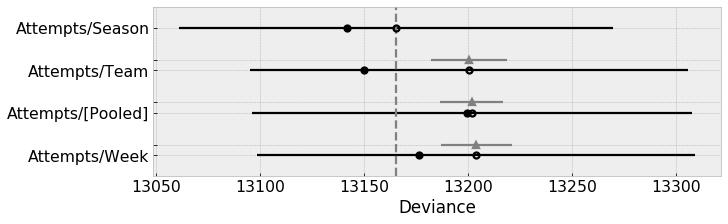

In [577]:
az.plot_compare(df_compare, figsize=(10, 3));

In [578]:
def make_ref_val(df, var_name, group_name, ref_col):
    return {var_name: [{group_name: g, "ref_val": r} for g, r in df[[group_name, ref_col]].values]}

In [579]:
def make_az_data(trace, var_name, col_name, col_values):
    
    return az.from_pymc3(trace, 
                         coords={col_name: col_values},
                         dims={var_name: [col_name]},
      )

In [580]:
attempts_season_ref_vals = make_ref_val(df_season, "theta", "season_code", "fourth_down_attempt_pct")

attempts_season_data = make_az_data(attempts_season_trace, "theta", "season_code", seasons)

In [581]:
attempts_season_ref_vals

{'theta': [{'season_code': 'R2009', 'ref_val': 0.17472353870458135},
  {'season_code': 'R2010', 'ref_val': 0.15311004784688995},
  {'season_code': 'R2011', 'ref_val': 0.1375968992248062},
  {'season_code': 'R2012', 'ref_val': 0.1440182054616385},
  {'season_code': 'R2013', 'ref_val': 0.14627241270839886},
  {'season_code': 'R2014', 'ref_val': 0.14716605899900564},
  {'season_code': 'R2015', 'ref_val': 0.153322528363047},
  {'season_code': 'R2016', 'ref_val': 0.15914409896355733},
  {'season_code': 'R2017', 'ref_val': 0.1525369299935774},
  {'season_code': 'R2018', 'ref_val': 0.182566918325326},
  {'season_code': 'R2019', 'ref_val': 0.19234913793103448}]}

In [599]:
def plot_forest(data, var, labels, title=None, is_percent=True):
    _, axes = az.plot_forest(data, kind="forestplot", var_names=[var], combined=True, figsize=(8, int(len(labels)*.4)), colors="cycle");
    axes[0].set_yticklabels(labels[::-1])
    vals = axes[0].get_xticks()
    if is_percent:
        _ = axes[0].set_xticklabels(['{:,.1%}'.format(x) for x in vals])
    if title:
        axes[0].set_title(title)

def plot_ridge(data, var, labels, title=None):
    _, axes = az.plot_forest(data, kind="ridgeplot", ridgeplot_overlap=1, 
                             var_names=[var], combined=True, figsize=(8, int(len(labels))), colors="lightblue");
    axes[0].set_yticklabels(labels[::-1])
    if title:
        axes[0].set_title(title)

        
def plot_bar(data, var, labels, title=None, colormap="tab20b"):
    ax = data.sort_values(by=var).plot(kind="barh", figsize=(10, 16), colormap=colormap);
    if title:
        ax.set_title(title)

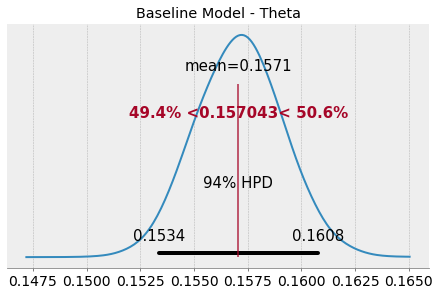

In [583]:
ax = pm.plot_posterior(attempts_trace, 
                  var_names=["theta"],
                  round_to=4,
                  ref_val=df_season["fourth_down_attempts"].sum()/df_season["fourth_down"].sum(),
                  
)
ax[0].set_title("Baseline Model - Theta");

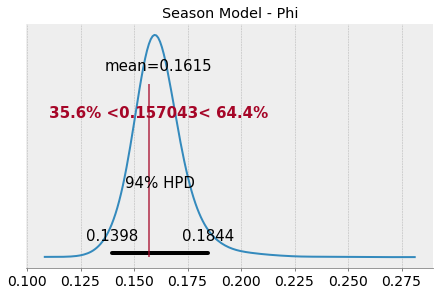

In [584]:
ax = pm.plot_posterior(attempts_season_data, 
                  var_names=["phi"],
                  round_to=4,
                  ref_val=df_season["fourth_down_attempts"].sum()/df_season["fourth_down"].sum())
ax[0].set_title("Season Model - Phi");

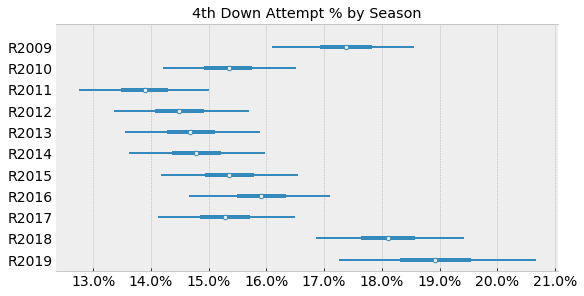

In [585]:
plot_forest(attempts_season_data, "theta", seasons, "4th Down Attempt % by Season");

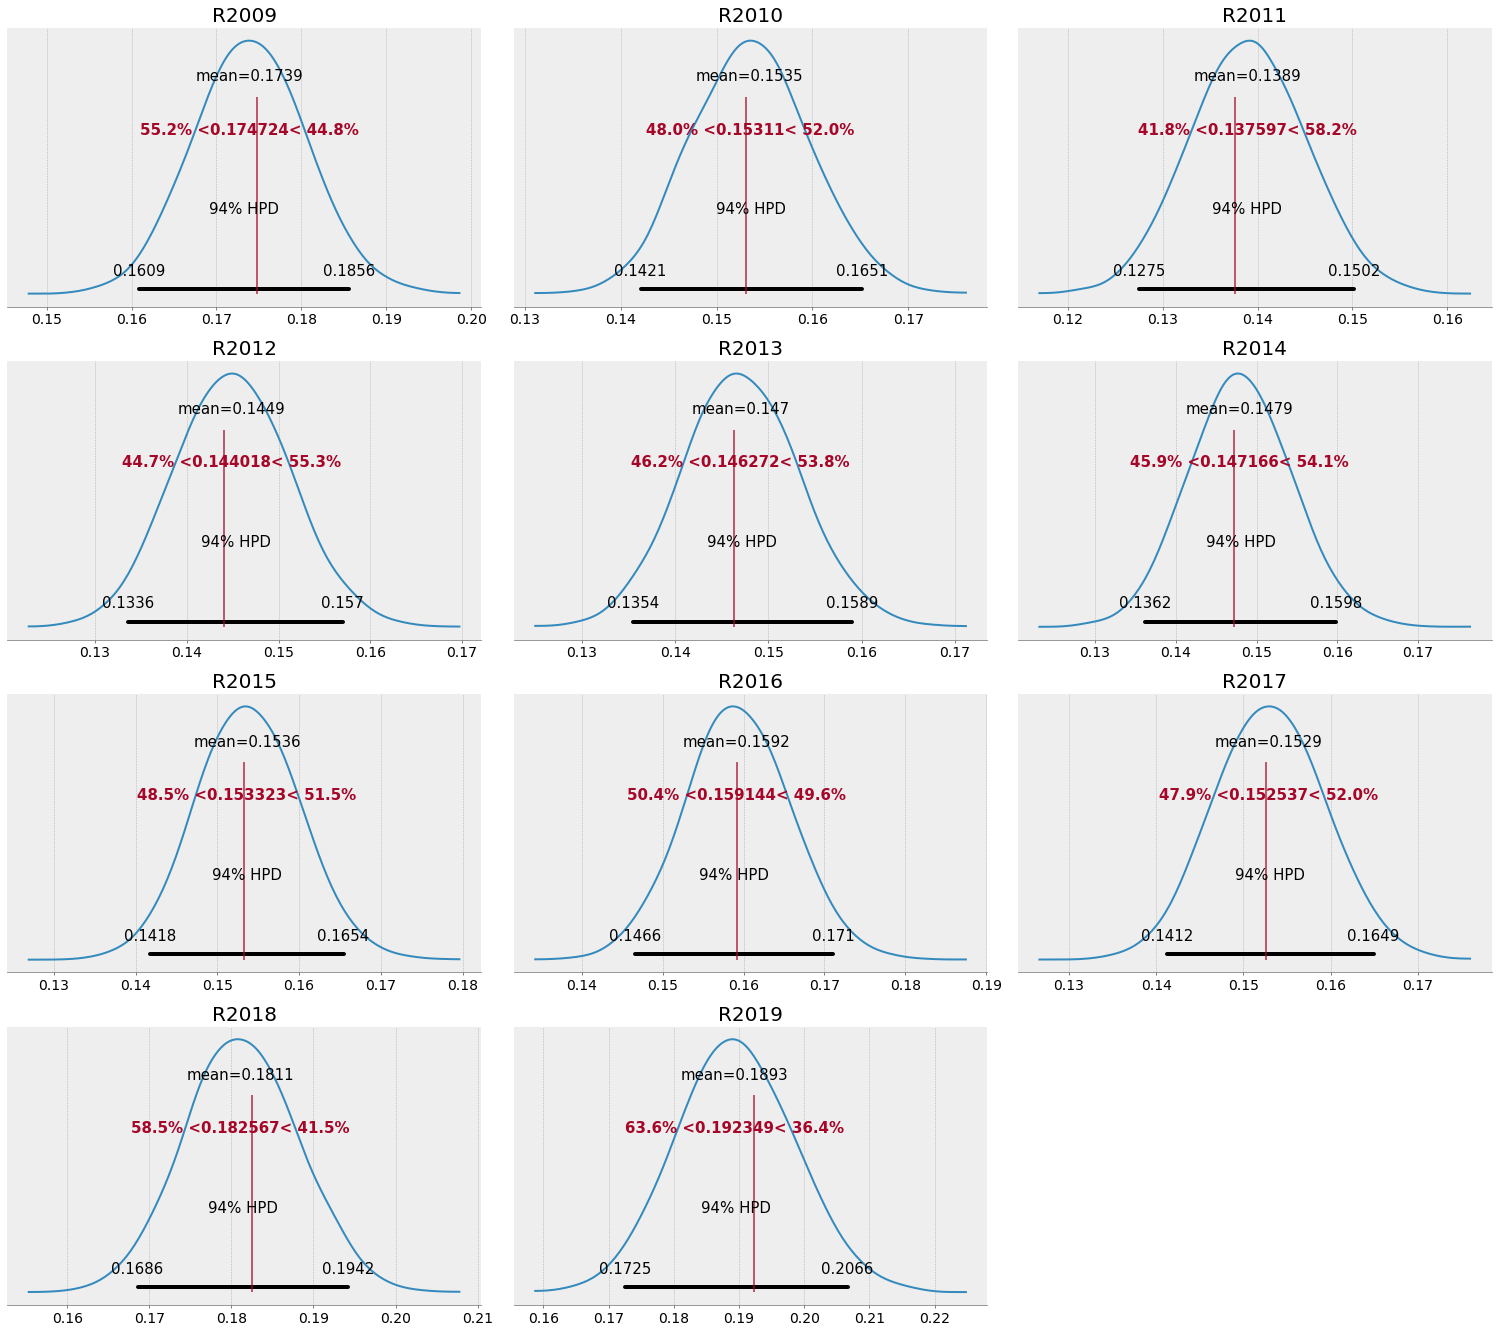

In [586]:
axes = pm.plot_posterior(attempts_season_data, 
                  var_names=["theta"],
                  round_to=4,
                  ref_val=attempts_season_ref_vals)
for ax, season in zip(axes, seasons):
    ax.set_title(season, fontsize=20);

In [588]:
attempts_team_ref_vals = make_ref_val(df_team, "theta", "team_code", "fourth_down_attempt_pct")
attempts_team_data = make_az_data(attempts_team_trace, "theta", "team_code", teams)

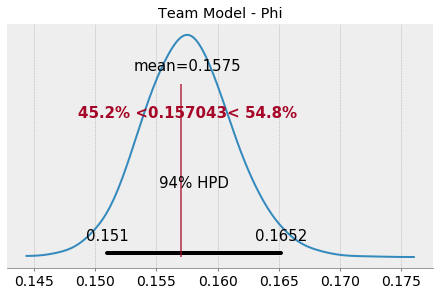

In [589]:
ax = pm.plot_posterior(attempts_team_data, 
                  var_names=["phi"],
                  round_to=4,
                  ref_val=df_team["fourth_down_attempts"].sum()/df_team["fourth_down"].sum())
ax[0].set_title("Team Model - Phi");

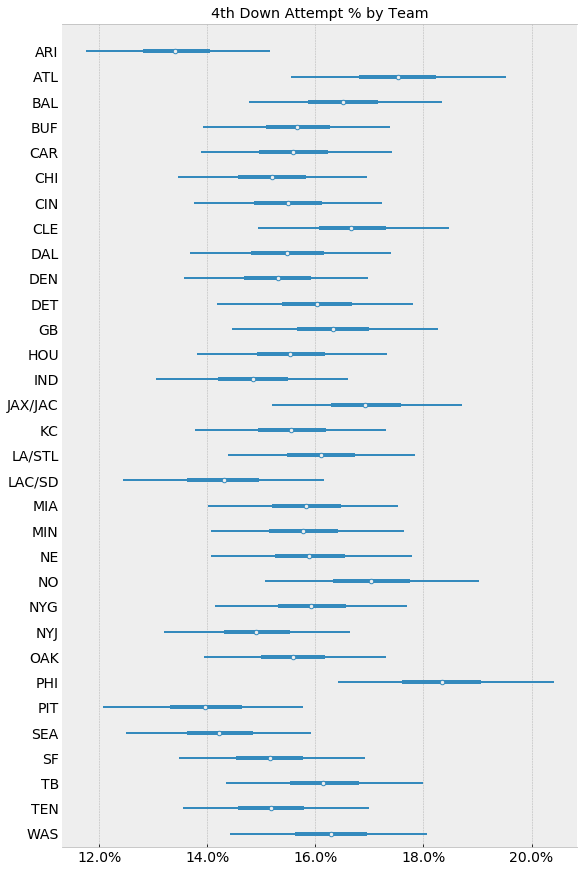

In [590]:
plot_forest(attempts_team_data, "theta", teams, "4th Down Attempt % by Team");

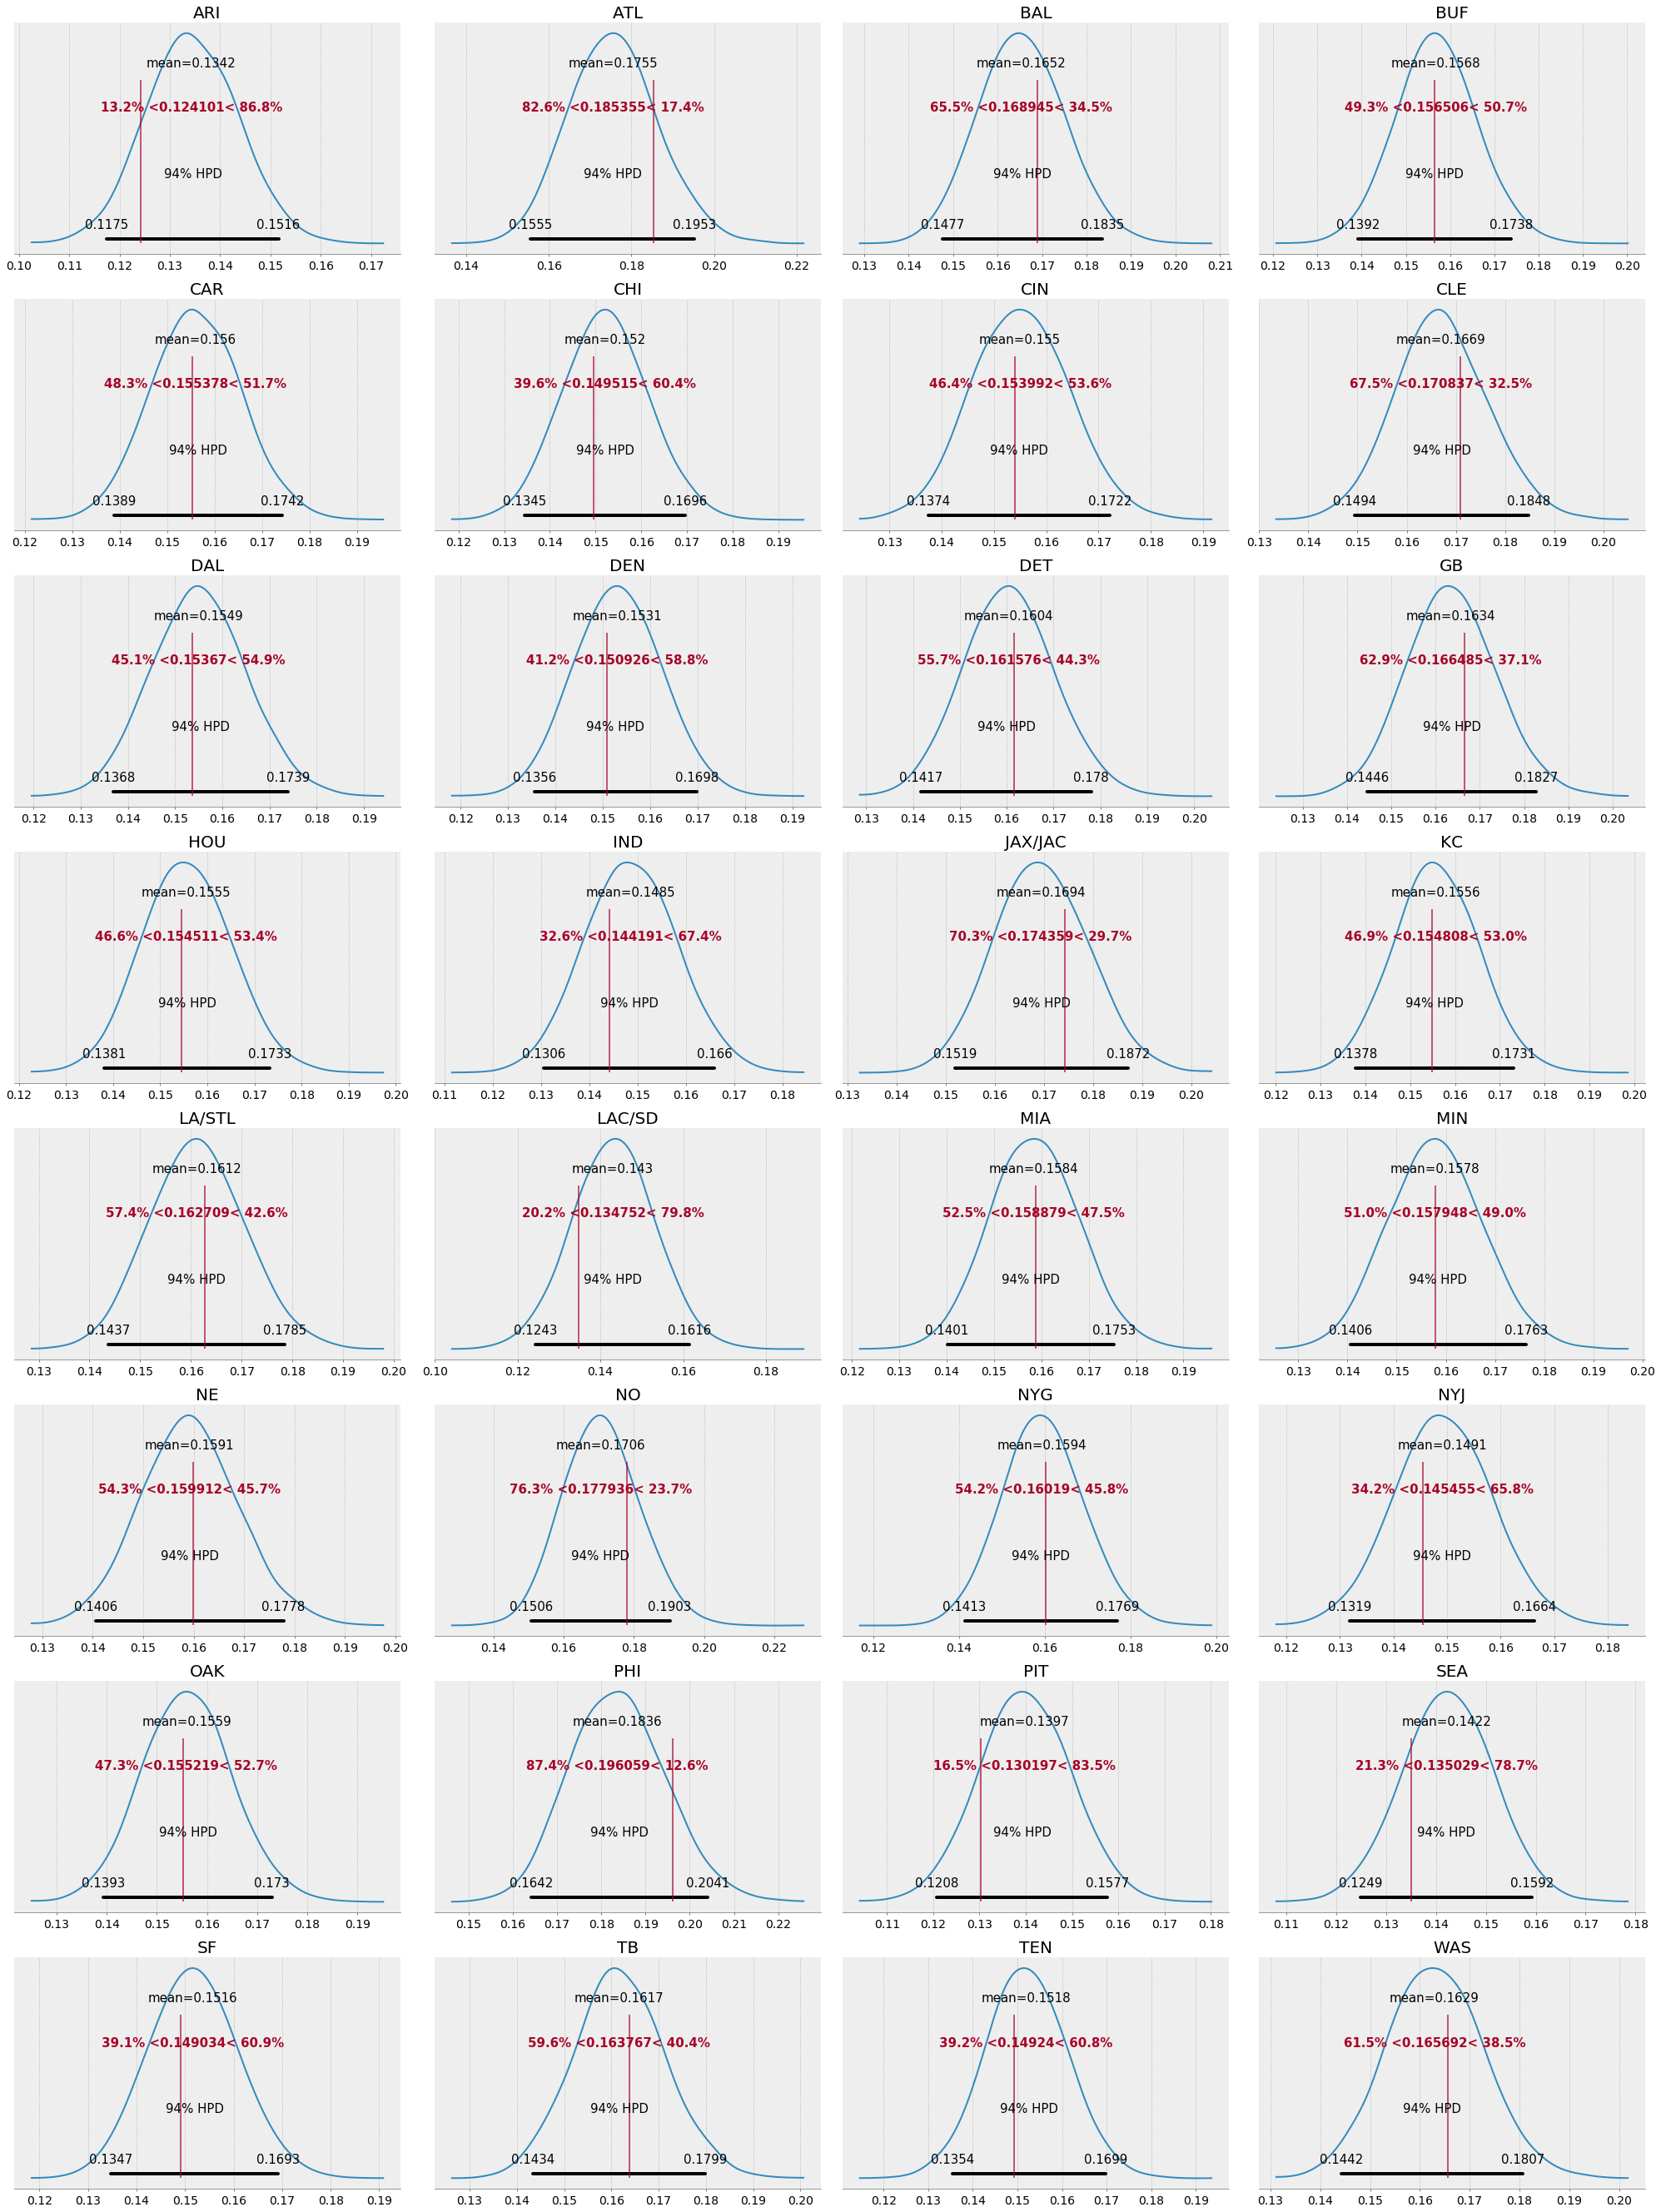

In [591]:
axes = pm.plot_posterior(attempts_team_data, 
                  var_names=["theta"], 
                  round_to=4,
                  ref_val=attempts_team_ref_vals)

for ax, team in zip(axes, teams):
    ax.set_title(team, fontsize=20)

In [592]:
df_week

,game_week_code,season_week,fourth_down,fourth_down_attempts,fourth_down_conversions,fourth_down_attempt_pct,fourth_down_conversion_pct
0,20100907,1,222,35,15,0.157658,0.428571
1,20100914,2,187,29,13,0.155080,0.448276
2,20100921,3,180,36,18,0.200000,0.500000
3,20100928,4,159,19,9,0.119497,0.473684
4,20101005,5,159,21,6,0.132075,0.285714
...,...,...,...,...,...,...,...
159,20191015,7,152,33,16,0.217105,0.484848
160,20191022,8,159,32,12,0.201258,0.375000
161,20191029,9,138,30,19,0.217391,0.633333
162,20191105,10,170,39,16,0.229412,0.410256


In [597]:
attempts_week_ref_vals = make_ref_val(df_week, "theta", "season_week", "fourth_down_attempt_pct")
attempts_week_data = make_az_data(attempts_week_trace, "theta", "season_week", weeks)

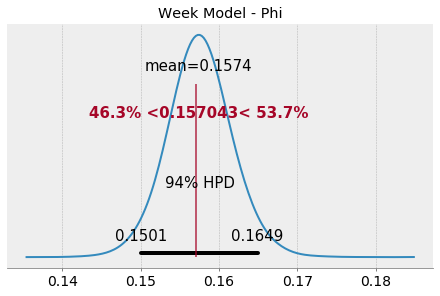

In [621]:
ax = pm.plot_posterior(attempts_week_data, 
                  var_names=["phi"],
                  round_to=4,
                  ref_val=df_week["fourth_down_attempts"].sum()/df_week["fourth_down"].sum())
ax[0].set_title("Week Model - Phi");

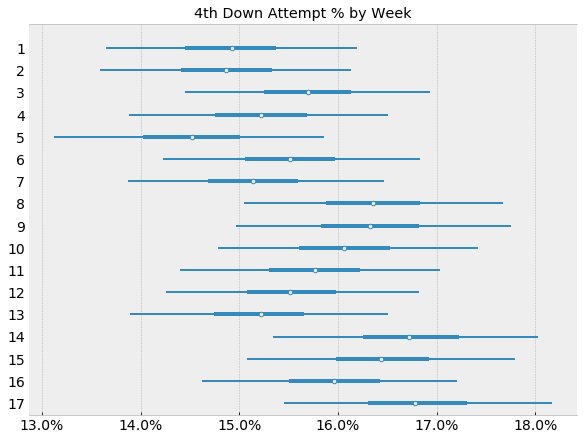

In [598]:
plot_forest(attempts_week_data, "theta", weeks, "4th Down Attempt % by Week");

In [ ]:
axes = pm.plot_posterior(attempts_week_data, 
                  var_names=["theta"],
                  round_to=4,
                  ref_val=attempts_week_ref_vals)
for ax, week in zip(axes, weeks):
    ax.set_title(week, fontsize=20);

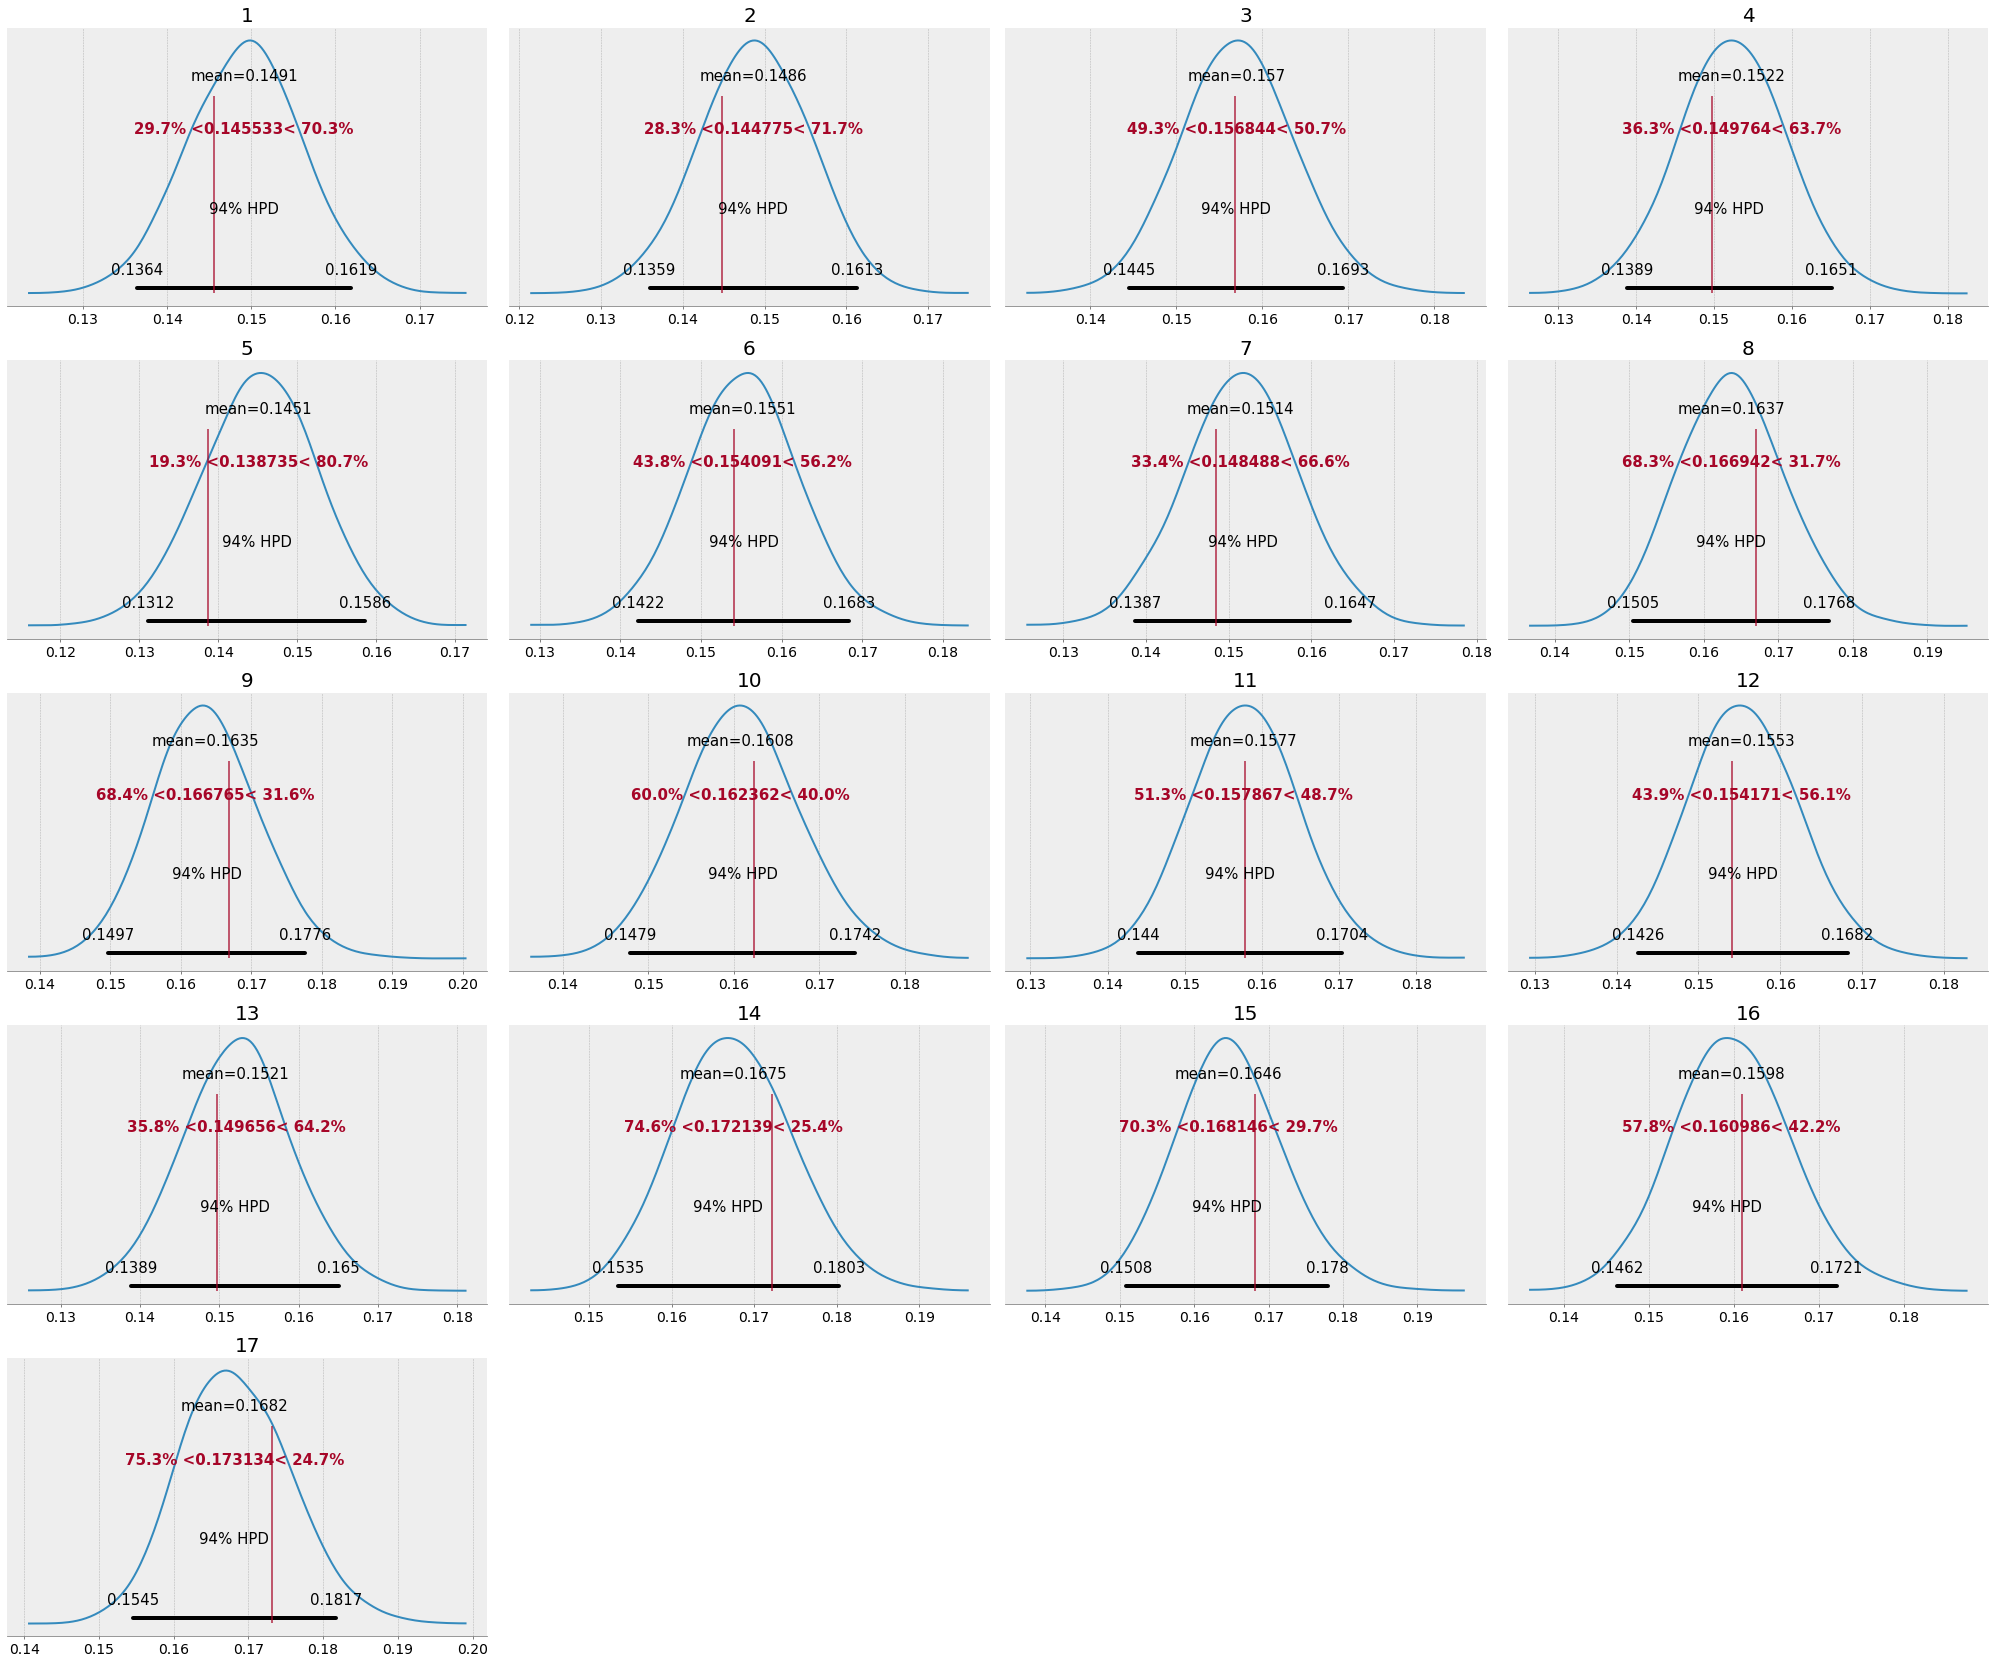

In [620]:
axes = pm.plot_posterior(attempts_week_data, 
                  var_names=["theta"],
                  round_to=4,
                  ref_val=attempts_week_ref_vals)
for ax, week in zip(axes, weeks):
    ax.set_title(week, fontsize=20);

In [718]:
def trace_to_dataframe(trace, var_name, columns, var_col_name):
    
    df_trace = pm.trace_to_dataframe(trace, varnames=[var_name])
    df_trace.columns = columns 
    df_trace = df_trace.melt(var_name=var_col_name, value_name=var_name)
    
    return df_trace


def trace_metrics(data, var_name):
    
    mean = data[var_name].mean(axis=0) 
    hpd = pm.hpd(data[var_name]) 
    hpd_l, hpd_u = [l for l,u in hpd], [u for l,u in hpd]
    return mean, hpd_l, hpd_u

In [615]:
df_trace_season = trace_to_dataframe(attempts_season_trace, var_name="theta", columns=seasons, var_col_name="season")
df_trace_week = trace_to_dataframe(attempts_week_trace, var_name="theta", columns=weeks, var_col_name="week")

In [610]:
df_trace_season

,season,theta
0,R2009,0.173282
1,R2009,0.175898
2,R2009,0.176335
3,R2009,0.170763
4,R2009,0.173271
...,...,...
131995,R2019,0.185697
131996,R2019,0.186518
131997,R2019,0.184864
131998,R2019,0.201351


In [607]:
df_trace_season.groupby("season").agg({"theta": lambda x: np.quantile(x, q=.95)})["theta"].values

array([0.18490703, 0.16379956, 0.14899944, 0.1553152 , 0.15743983,
       0.15846765, 0.16407392, 0.16985295, 0.16347452, 0.19261725,
       0.20440322])

In [616]:
attempts_season_mean, attempts_season_hpd_l, attempts_season_hpd_u = trace_metrics(attempts_season_trace, "theta")
attempts_week_mean, attempts_week_hpd_l, attempts_week_hpd_u = trace_metrics(attempts_week_trace, "theta")

In [613]:
# attempts_season_hpd_hpd_r = [u-l for l, u in attempts_season_hpd]

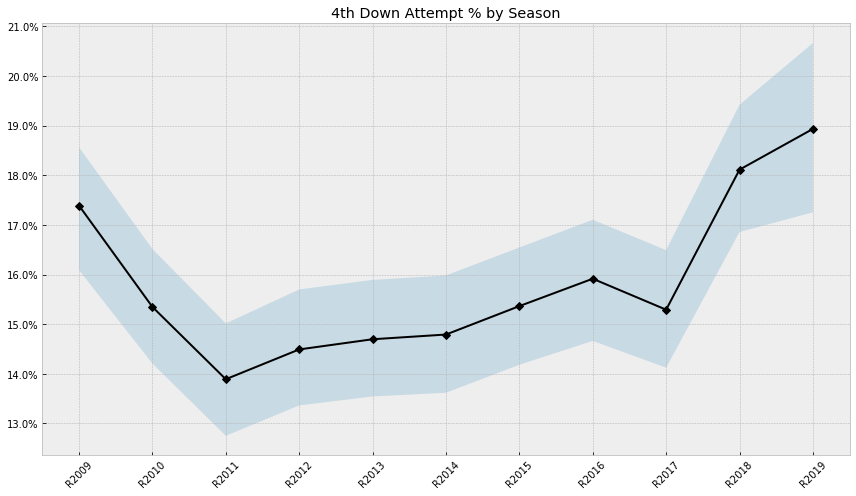

In [617]:
_, ax = plt.subplots(1,1,figsize=(12, 7))
ax.plot(seasons, attempts_season_mean, color="k", marker="D")
ax.fill_between(seasons, attempts_season_hpd_l, attempts_season_hpd_u, alpha=.2)
ax.set_xticks(seasons)
_ = ax.set_xticklabels(seasons, rotation=45)
# x_vals = vals = ax.get_xticks()
# print(x_vals)
vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
ax.set_xlabel(None)
ax.set_title("4th Down Attempt % by Season")
plt.tight_layout();

<!-- ValueError: Colormap tab1 is not recognized. Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cividis, cividis_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, icefire, icefire_r, inferno, inferno_r, jet, jet_r, magma, magma_r, mako, mako_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, rocket, rocket_r, seismic, seismic_r, spring, spring_r, summer, summer_r, tab10, tab10_r, tab20, tab20_r, tab20b, tab20b_r, tab20c, tab20c_r, terrain, terrain_r, twilight, twilight_r, twilight_shifted, twilight_shifted_r, viridis, viridis_r, vlag, vlag_r, winter, winter_r
 -->

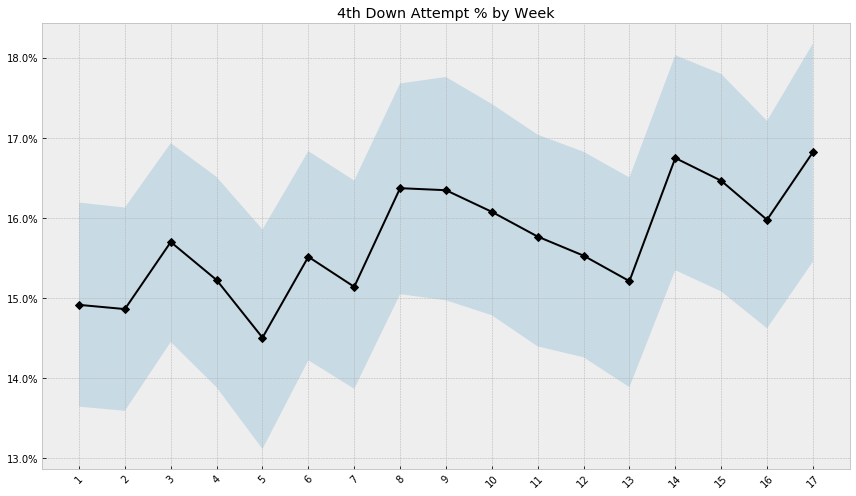

In [618]:
_, ax = plt.subplots(1,1,figsize=(12, 7))
ax.plot(weeks, attempts_week_mean, color="k", marker="D")
ax.fill_between(weeks, attempts_week_hpd_l, attempts_week_hpd_u, alpha=.2)
ax.set_xticks(weeks)
_ = ax.set_xticklabels(weeks, rotation=45)
# x_vals = vals = ax.get_xticks()
# print(x_vals)
vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
ax.set_xlabel(None)
ax.set_title("4th Down Attempt % by Week")
plt.tight_layout();

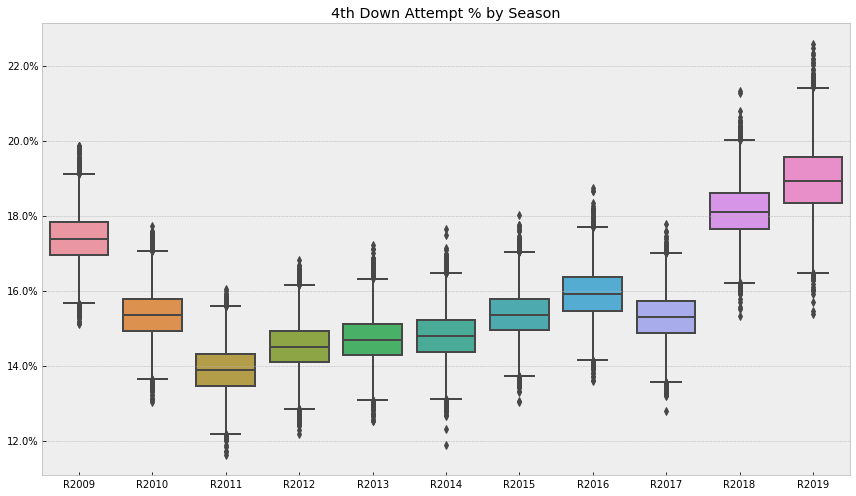

In [522]:
_, ax = plt.subplots(1,1,figsize=(12, 7))
sns.boxplot(x="season", y="theta", data=df_trace_season, ax=ax)
vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title("4th Down Attempt % by Season")
plt.tight_layout();

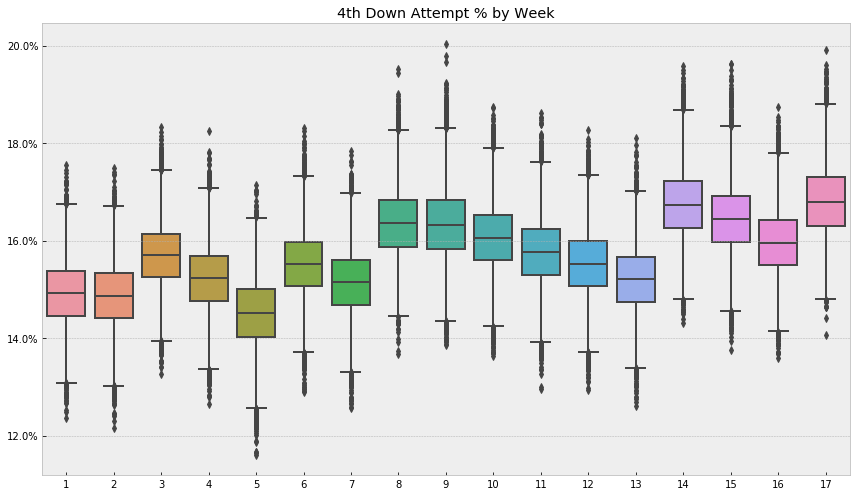

In [619]:
_, ax = plt.subplots(1,1,figsize=(12, 7))
sns.boxplot(x="week", y="theta", data=df_trace_week, ax=ax)
vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.set_title("4th Down Attempt % by Week")
plt.tight_layout();

## Linear Model

In [767]:
with pm.Model() as attempts_week_linear_model:
    
    α = pm.Normal("α", mu=0, sd=20)
    
    β = pm.Normal("β", mu=0, sd=20)
    
    σ = pm.HalfNormal("σ", sd=20)
    μ = α + β*df_week["season_week"]
    
    y_attempt_ratio = pm.Normal("y_attempt_ratio", mu=μ, sd=σ, observed=df_week["fourth_down_attempt_pct"])

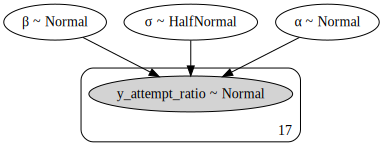

In [768]:
pm.model_to_graphviz(attempts_week_linear_model)

In [769]:
attempts_week_linear_model

In [770]:
with attempts_week_linear_model:
    attempts_week_linear_trace = pm.sample(**SAMPLE_KWARGS)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [σ, β, α]
Sampling 3 chains, 0 divergences: 100%|██████████| 18000/18000 [00:12<00:00, 1425.56draws/s]


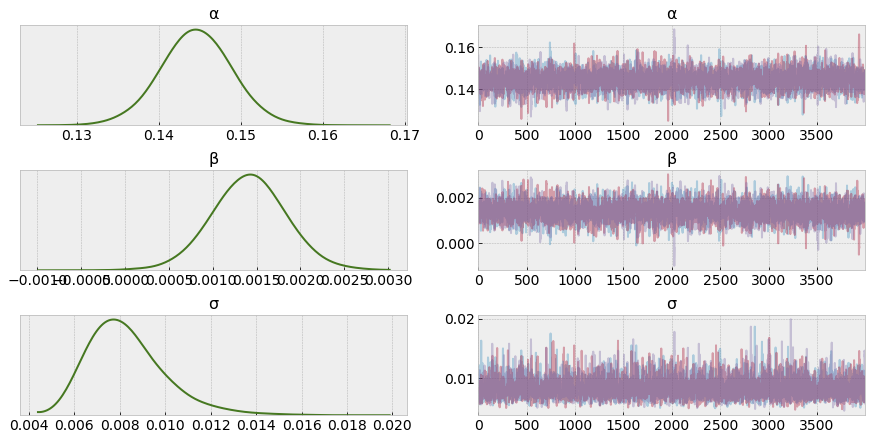

In [771]:
pm.traceplot(attempts_week_linear_trace, combined=True, compact=True);

In [772]:
with attempts_week_linear_model:
    linear_ppc = pm.sample_posterior_predictive(attempts_week_linear_trace)

100%|██████████| 12000/12000 [00:10<00:00, 1195.12it/s]


In [773]:
y_m, y_l, y_u = trace_metrics(linear_ppc, "y_attempt_ratio")

In [774]:
y_m.shape

(17,)

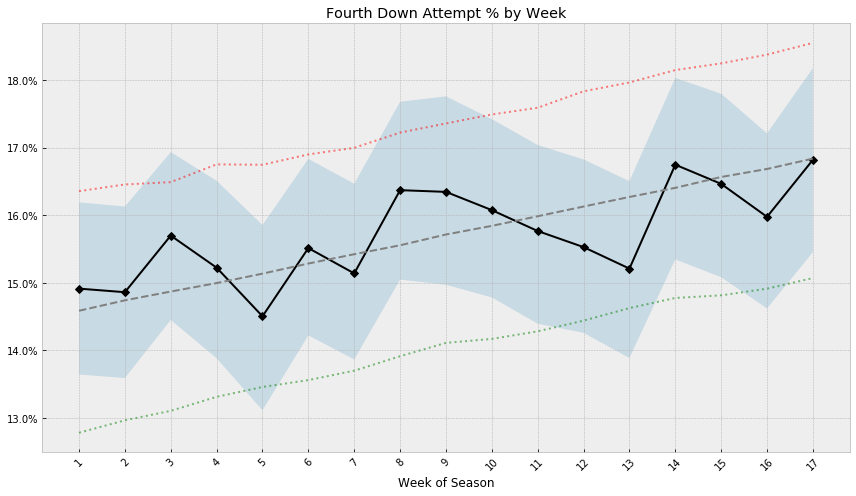

In [775]:
_, ax = plt.subplots(1,1,figsize=(12, 7))
ax.plot(weeks, attempts_week_mean, color="k", marker="D")
ax.fill_between(weeks, attempts_week_hpd_l, attempts_week_hpd_u, alpha=.2)

ax.plot(weeks, y_l, color="g", linestyle="dotted", alpha=.5)
ax.plot(weeks, y_m, color="grey", linestyle="dashed")
ax.plot(weeks, y_u, color="r", linestyle="dotted", alpha=.5)
# y_m, , y_u

ax.set_xticks(weeks)
_ = ax.set_xticklabels(weeks, rotation=45)
# x_vals = vals = ax.get_xticks()
# print(x_vals)
vals = ax.get_yticks()
_ = ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
ax.set_xlabel("Week of Season")
ax.set_title("Fourth Down Attempt % by Week")
plt.tight_layout();